In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
x_len = 3000

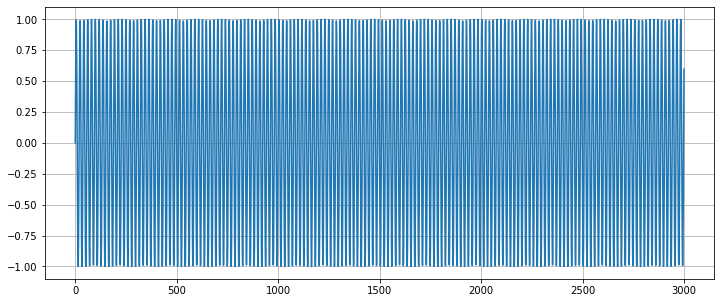

In [3]:
w1 = np.linspace(0, x_len-1, x_len)
# wave1 = np.sin(w1*2*5/50)+(np.random.rand(1000)/30)
wave1 = np.sin(w1*2*5/30, dtype=np.float32)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave1)
plt.show()

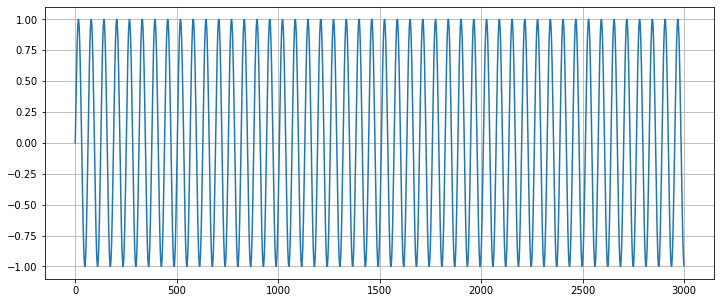

In [4]:
w2 = np.linspace(0, x_len-1, x_len)
wave2 = np.sin(w2*2*5/100, dtype=np.float32)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave2)
plt.show()

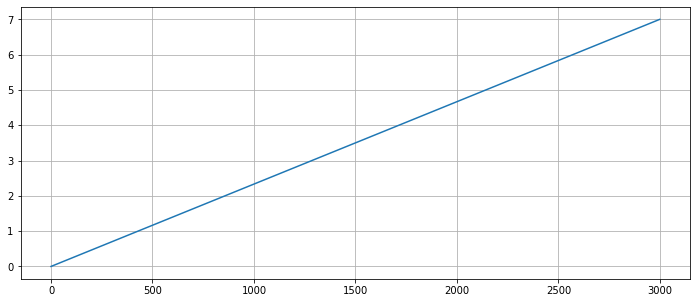

In [5]:
straight_a = np.linspace(0, 7, x_len, dtype=np.float32)
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(straight_a)
plt.show()

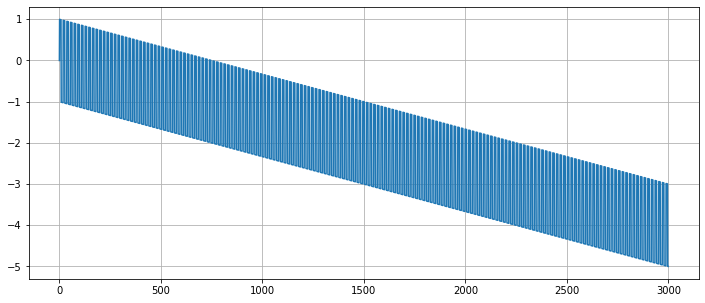

In [6]:
pack = []
j = 0
for i in range(x_len):
    if i % 9 == 0:
        if i % 2 == 0:
            pack.append(j)
            j =+ 1
        else:
            j =- 1
            pack.append(j)
    else:
        pack.append(j)

pack_array = np.array(pack, dtype=np.float32)

straight_b = np.linspace(0, -4, x_len, dtype=np.float32)
straight_pack = straight_b + pack_array
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(straight_pack)
plt.show()

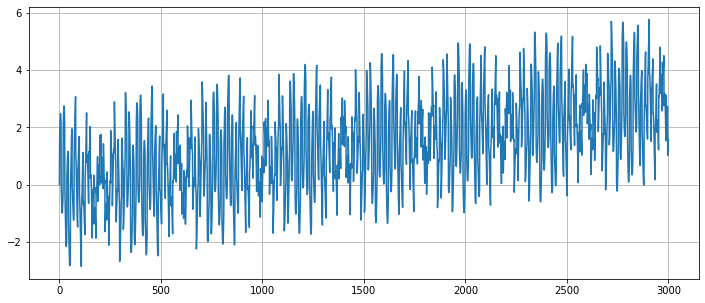

In [7]:
wave = wave1 + wave2 + straight_a + straight_pack
plt.figure(figsize=(12, 5))
plt.grid(True)
plt.plot(wave)
plt.show()

In [8]:
#時系列を最終次元にする
data = np.stack([wave, wave1, wave2, straight_a, straight_pack], 0)
print(data.shape)
data[:3]

(5, 3000)


array([[ 0.        ,  1.4280285 ,  1.8190398 , ...,  1.0229611 ,
         1.3256211 ,  1.6048198 ],
       [ 0.        ,  0.32719472,  0.6183698 , ..., -0.02646075,
         0.30205646,  0.59737444],
       [ 0.        ,  0.09983342,  0.19866933, ..., -0.9485771 ,
        -0.97543466, -0.9925545 ]], dtype=float32)

In [9]:
test_size=100
train = data[:, :-test_size]
test = data[:, -test_size:]

In [10]:
train.shape

(5, 2900)

In [11]:
#Dataset用 sequence_creator
def sequence_creator(input_data, window):
    window_fr_data = []
    label_data = []
    data_len = len(input_data[0])
    
    for i in range(data_len-window):
        window_fr = input_data[:, i:i+window]
        label = input_data[:, i+window:i+window+1]
        
        window_fr_data.append(window_fr)
        label_data.append(label)
        
    return window_fr_data, label_data

In [12]:
window = 50
train_x, train_y = sequence_creator(train,window)

In [13]:
#Dataset作成
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, window, label):
        self.window = window
        self.label = label
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        out_window = self.window[idx]
        out_label = self.label[idx]
        
        return out_window, out_label

In [14]:
train_set = MyDataset(train_x, train_y)

In [15]:
batch_size = 8
dataloader = DataLoader(train_set, batch_size, drop_last=True, shuffle=False)

In [16]:
for X,y in dataloader:
    break
    
print(X)
print(y)

tensor([[[ 0.0000e+00,  1.4280e+00,  1.8190e+00,  ..., -1.9116e+00,
          -2.2361e+00, -2.5188e+00],
         [ 0.0000e+00,  3.2719e-01,  6.1837e-01,  ...,  4.1285e-02,
          -2.8790e-01, -5.8540e-01],
         [ 0.0000e+00,  9.9833e-02,  1.9867e-01,  ..., -9.9992e-01,
          -9.9616e-01, -9.8245e-01],
         [ 0.0000e+00,  2.3341e-03,  4.6682e-03,  ...,  1.0970e-01,
           1.1204e-01,  1.1437e-01],
         [ 0.0000e+00,  9.9867e-01,  9.9733e-01,  ..., -1.0627e+00,
          -1.0640e+00, -1.0654e+00]],

        [[ 1.4280e+00,  1.8190e+00,  2.1400e+00,  ..., -2.2361e+00,
          -2.5188e+00, -2.7274e+00],
         [ 3.2719e-01,  6.1837e-01,  8.4147e-01,  ..., -2.8790e-01,
          -5.8540e-01, -8.1845e-01],
         [ 9.9833e-02,  1.9867e-01,  2.9552e-01,  ..., -9.9616e-01,
          -9.8245e-01, -9.5892e-01],
         [ 2.3341e-03,  4.6682e-03,  7.0023e-03,  ...,  1.1204e-01,
           1.1437e-01,  1.1671e-01],
         [ 9.9867e-01,  9.9733e-01,  9.9600e-01,  ...

In [17]:
#batch_size, features, sequece_len)
print(X.shape)
print(y.shape)

torch.Size([8, 5, 50])
torch.Size([8, 5, 1])


In [18]:
#畳み込みを行う次元（時系列）の出力される要素数確認
test_model = nn.Sequential(
    nn.Conv1d(5, 100, 3, padding=1),
#     nn.ReLU(),
#     nn.Conv1d(100, 50, 5, stride=2, padding=1),
#     nn.ReLU(),
#     nn.Conv1d(50, 5, 3),
        )

test_model(X).shape

torch.Size([8, 100, 50])

In [19]:
#モデル作成
import torch.nn.functional as F
class Model(nn.Module):
    def __init__(self, hidden_size=32):
        super(Model, self).__init__()
        self.conv1 = nn.Conv1d(5, 100, 3, padding=1)
        self.conv2 = nn.Conv1d(100, 50, 5, stride=2, padding=1)
        self.conv3 = nn.Conv1d(50, 5, 3)
        self.lstm = nn.LSTM(5, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 5)
        
    def forward(self, input_seq):
        input_seq = F.relu(self.conv1(input_seq))
        input_seq = F.relu(self.conv2(input_seq))
        input_seq = self.conv3(input_seq)
        input_seq = input_seq.permute(0,2,1)
        
        batch_size, seq_len, feature_size = input_seq.shape[0], input_seq.shape[1], input_seq.shape[2]
        lstm_out, hidden = self.lstm(input_seq.reshape(batch_size, seq_len, feature_size))
        lstm_out_last = lstm_out[:, -1]
        predictions = self.linear(lstm_out_last.reshape(batch_size, -1)).reshape(batch_size, 1, feature_size)
        
        return predictions
    
model = Model()

In [20]:
############################################
print(torch.cuda.is_available())
cuda = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu = torch.device("cpu")
print(cuda)

True
cuda:0


In [21]:
model.to(cuda)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [22]:
model.train()

Model(
  (conv1): Conv1d(5, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 50, kernel_size=(5,), stride=(2,), padding=(1,))
  (conv3): Conv1d(50, 5, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(5, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=5, bias=True)
)

In [23]:
from tqdm.notebook import tqdm
epochs = 100
loss = []
for i in tqdm(range(epochs)):
    train_loss = 0
    for X,y in dataloader:
        X = X.to(cuda)
        y = y.to(cuda)
        y = y.permute(0,2,1)
        optimizer.zero_grad()
        y_pred = model(X)
        
        single_loss = criterion(y_pred, y)
        single_loss.backward()
        optimizer.step()
        train_loss += single_loss.detach().item()

    train_loss /= len(dataloader)
    loss.append(train_loss)
    
    if (i+1) % 5 == 0:
        print(f'epoch: {i+1} Loss: {train_loss}')

  0%|          | 0/100 [00:00<?, ?it/s]

epoch: 5 Loss: 0.24206017136699362
epoch: 10 Loss: 0.021871475976358138
epoch: 15 Loss: 0.010905964649282396
epoch: 20 Loss: 0.010660920559959696
epoch: 25 Loss: 0.011088471043805247
epoch: 30 Loss: 0.011856625243443263
epoch: 35 Loss: 0.011083197753792733
epoch: 40 Loss: 0.01127292312193777
epoch: 45 Loss: 0.0159095254202839
epoch: 50 Loss: 0.014289099393475257
epoch: 55 Loss: 0.0371157588696191
epoch: 60 Loss: 0.02210494060085019
epoch: 65 Loss: 0.0259349607611389
epoch: 70 Loss: 0.016437264687768863
epoch: 75 Loss: 0.013732405038670835
epoch: 80 Loss: 0.006297897308276118
epoch: 85 Loss: 0.010546903088008671
epoch: 90 Loss: 0.011115325548754105
epoch: 95 Loss: 0.009037517097986596
epoch: 100 Loss: 0.004506901785890896


In [24]:
y_pred.shape

torch.Size([8, 1, 5])

In [25]:
y.shape

torch.Size([8, 1, 5])

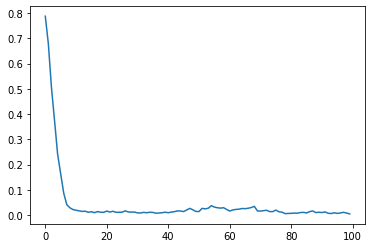

In [26]:
plt.plot(loss)

In [27]:
model.eval()

Model(
  (conv1): Conv1d(5, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 50, kernel_size=(5,), stride=(2,), padding=(1,))
  (conv3): Conv1d(50, 5, kernel_size=(3,), stride=(1,))
  (lstm): LSTM(5, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=5, bias=True)
)

In [28]:
test.shape

(5, 100)

In [29]:
pred_list = []
for i in range(len(test[0])-window):
    sequence_in = torch.FloatTensor(test[:, i:i+window]).to(cuda).reshape(1, -1, window)
    
    with torch.no_grad():
        pred = model(sequence_in)
        pred_list.append(np.array(pred.reshape(-1).to(cpu)))

In [30]:
pred.shape

torch.Size([1, 1, 5])

In [31]:
pred.reshape(-1)

tensor([ 1.5497,  0.5433, -0.9060,  6.8241, -4.9183], device='cuda:0')

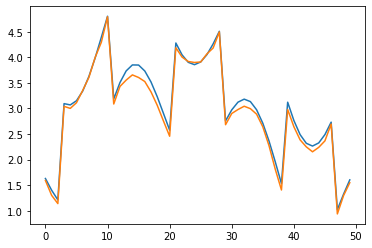

In [32]:
plt.plot(test[0, -50:])
plt.plot(np.array(pred_list)[:, 0])